In [1]:
# pandas to create small dataframes 
import pandas as pd
import numpy as np

# general purpose packages
import os
import sys
import random
from datetime import datetime
from itertools import product

# visualization related packages
import matplotlib.pylab as plt
import seaborn as sns
sns.set()

# model, file saving packages
import pickle


# Graph package
import networkx as nx

# singular value decomposition relataed package
from scipy.sparse.linalg import svds, eigs

# package for partitioning the dataset into train, test
from sklearn.model_selection import train_test_split

<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

### Problem statement: 
Given a directed social graph, have to predict missing links to recommend users (Link Prediction in graph)

### Data Overview
Taken data from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  
data contains two columns source and destination eac edge in graph 
    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  

### Mapping the problem into supervised learning problem:
- Generated training samples of good and bad links from given directed graph and for each link got some features like no of followers, is he followed back, page rank, katz score, adar index, some svd fetures of adj matrix, some weight features etc. and trained ml model based on these features to predict link. 
- Some reference papers and videos :  
    - https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    - https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
    - https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
    - https://www.youtube.com/watch?v=2M77Hgy17cg

### Business objectives and constraints:  
- No low-latency requirement.
- Probability of prediction is useful to recommend ighest probability links

### Performance metric for supervised learning:  
- Both precision and recall is important so F1 score is good choice
- Confusion matrix

# Configs

In [2]:
# path for existing edges & missing edges
input_graph_csv_path = '/media/amd_3/20DAD539DAD50BC2/DSET_REPO/DataSets/Facebook/data/train.csv'

In [3]:
# The below files will be created if doesnt exist.
missing_egde_csv_path = './data/missing_edges.csv'

train_labeled_csv_path = './data/Train_labeled.csv'
test_labeled_csv_path = './data/Test_labeled.csv'

In [4]:
dataset_sample_size = 100000

# Create G

In [5]:
def create_graph_from_dataframe(graph_df):

    # remove duplicates
    duplicated_info_series = graph_df.duplicated(subset=['source_node', 
                                       'destination_node'], 
                                       keep='first')
    
    graph_df = graph_df[~duplicated_info_series]
    
    # create graph
    G = nx.from_pandas_edgelist(df=graph_df, source='source_node', 
                                target='destination_node', 
                                edge_attr=None, 
                                create_using=nx.DiGraph())
    
    # Basic information about this graph
    print('Graph basic info:\n', nx.info(G))
    
    return G

In [6]:
input_df = pd.read_csv(input_graph_csv_path, index_col=False)
print('Input df shape : ', input_df.shape)
input_df.head()

Input df shape :  (9437519, 2)


,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


In [7]:
# create input graph
G_input = create_graph_from_dataframe(input_df)

Graph basic info:
 Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


## Displaying a subgraph

Graph basic info:
 Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576
Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


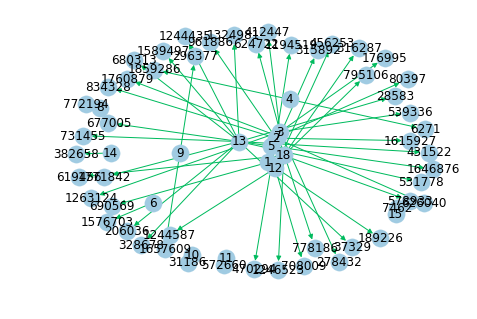

In [8]:
input_df_sample = input_df.iloc[0:50, :]
subgraph = create_graph_from_dataframe(input_df_sample)
pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,
        edge_cmap=plt.cm.Blues, with_labels=True)
plt.savefig('./data/graph_sample.pdf')
print(nx.info(subgraph))

# Exploratory Data Analysis

In [9]:
# No of Unique persons 
print('The number of unique persons',len(G_input.nodes()))

The number of unique persons 1862220


## Number of followers of each person

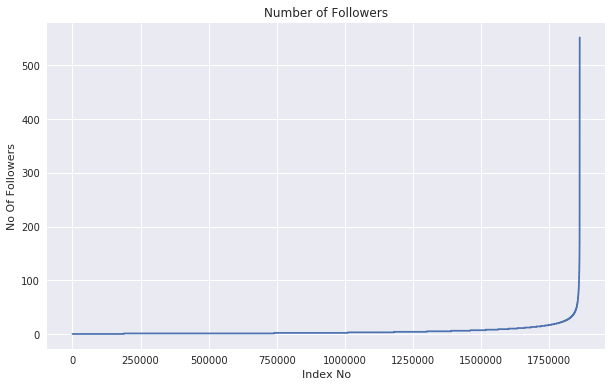

In [10]:
indegree_dist = list(dict(G_input.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.title('Number of Followers')
plt.show()
plt.close()

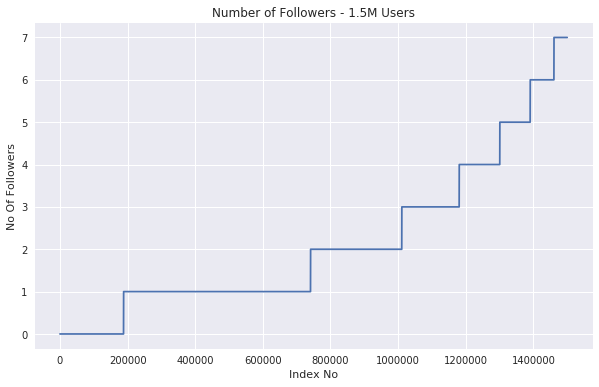

In [11]:
indegree_dist = list(dict(G_input.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.title('Number of Followers - 1.5M Users')
plt.show()
plt.close()

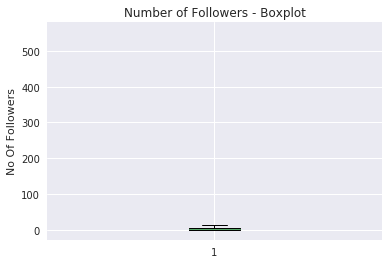

In [12]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.title('Number of Followers - Boxplot')
plt.show()
plt.close()

In [13]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


In [14]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


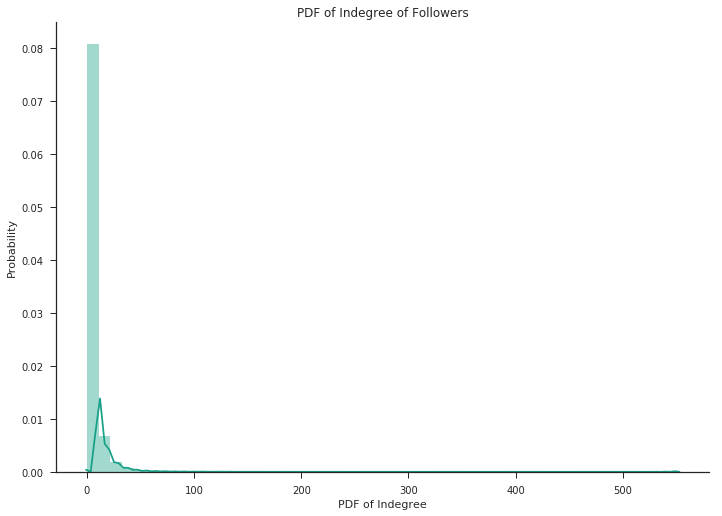

In [15]:
%matplotlib inline
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(indegree_dist, color='#16A085')
plt.xlabel('PDF of Indegree')
plt.ylabel('Probability')
plt.title('PDF of Indegree of Followers')
sns.despine()
plt.show()
plt.close()

## Number of followees of each person

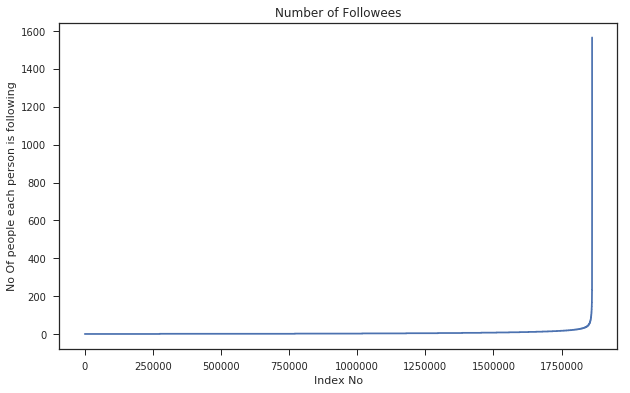

In [16]:
outdegree_dist = list(dict(G_input.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.title('Number of Followees')
plt.show()
plt.close()

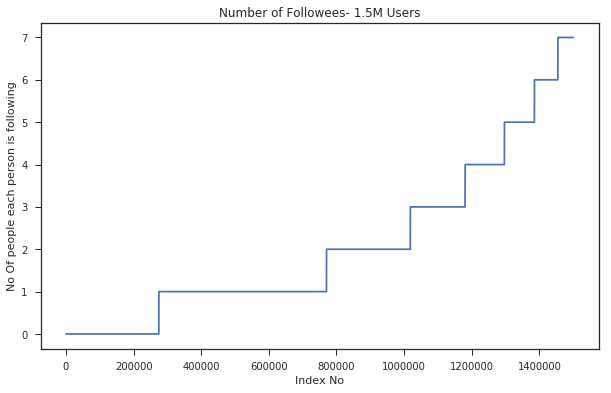

In [17]:
indegree_dist = list(dict(G_input.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.title('Number of Followees- 1.5M Users')
plt.show()
plt.close()

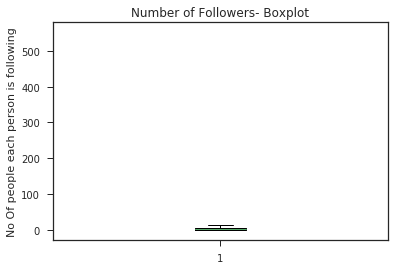

In [18]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of people each person is following')
plt.title('Number of Followers- Boxplot')
plt.show()
plt.close()

In [19]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


In [20]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


/home/amd_3/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


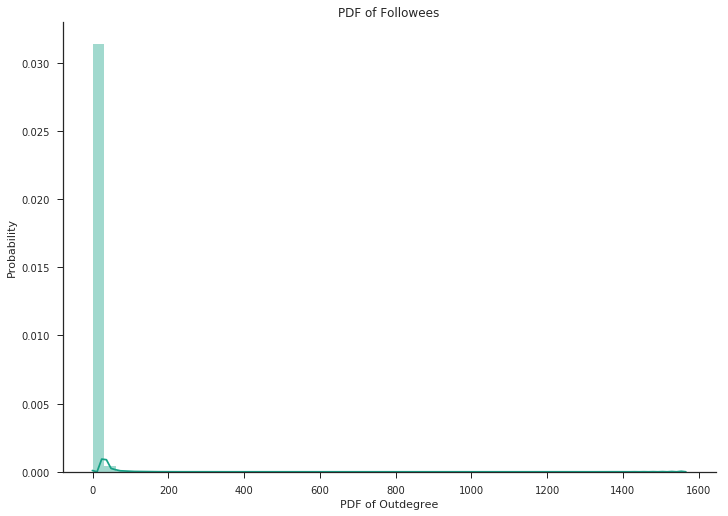

In [21]:
sns.set_style('ticks')
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.distplot(outdegree_dist, color='#16A085')
plt.xlabel('PDF of Outdegree')
plt.ylabel('Probability')
sns.despine()
plt.title('PDF of Followees')
plt.show()
plt.close()

In [22]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [23]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist) )

No of persons having zero followers are 188043 and % is 10.097786512871734


In [24]:
count=0
for i in G_input.nodes():
    if len(list(G_input.predecessors(i)))==0 :
        if len(list(G_input.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


## 3) both followers + following

In [25]:
from collections import Counter
dict_in = dict(G_input.in_degree())
dict_out = dict(G_input.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

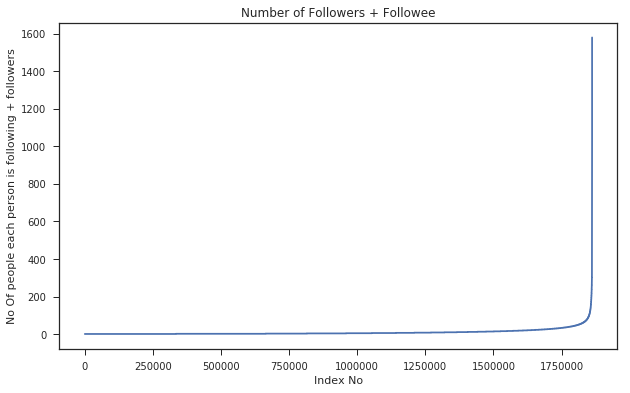

In [26]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.title('Number of Followers + Followee')
plt.show()
plt.close()

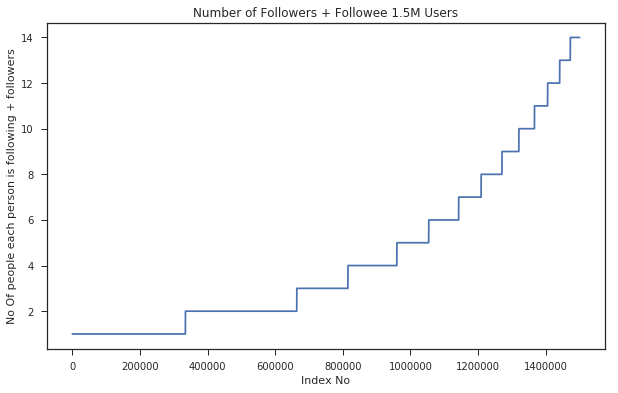

In [27]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.title('Number of Followers + Followee 1.5M Users')
plt.show()
plt.close()

In [28]:
### 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [29]:
### 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


In [30]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [31]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following


In [32]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


In [33]:
print('No of weakly connected components',
      len(list(nx.weakly_connected_components(G_input))))
count=0
for i in list(nx.weakly_connected_components(G_input)):
    if len(i)==2:
        count+=1
print('weakly connected components with 2 nodes',count)

No of weakly connected components 45558
weakly connected components with 2 nodes 32195


# Generate the edges not present

In [34]:
def two_rechable_nodes(G, node):
    
    # get all the followees of this node in a set
    node_followees = set(G.successors(node))
    
    # get followees followees (i.e. length 2)
    for temp_node in node_followees:
        node_followees = node_followees.union(set(G.successors(temp_node)))
        
    # add the node itself in the set
    node_followees.add(node)
    
    return node_followees

In [35]:
def get_missing_edges(index_dict, current_node, lb, ub, node_set, num_edges):
    
    # declare an empty list for adding all the missig edges
    selected_edge_list = list()
    
    while(len(selected_edge_list) < num_edges):
        # generate a random index in the range
        index = np.random.randint(lb,ub)
        # get the node corresponding to this index
        index_node = index_dict[index]
        
        # test the node already present in the node_set
        if  index_node in node_set:
            continue
          
        # update the selected edge list
        selected_edge_list.append((current_node, index_node,))
        
    return set(selected_edge_list)

In [36]:
def create_missing_edges(G):
    
    if os.path.isfile(missing_egde_csv_path):
        print(datetime.now(), ' Missing edges file already created !!!')
        missing_df = pd.read_csv(missing_egde_csv_path, index_col=False)
        return missing_df
    
    print(datetime.now(), ' Started adding the missing edges')
    
    num_edges = G.number_of_edges()
    print(datetime.now(), ' Number of edges present in the graph :', num_edges)
    
    # separate source nodes, destination edges
    src_nodes_set = set([item[0] for item in nx.edges(G)])
    dst_nodes_set = set([item[1] for item in  nx.edges(G)])
    # compute nodes which are present both in src as well as destination
    common_nodes = src_nodes_set.intersection(dst_nodes_set)
    
    print(datetime.now(), ' Common nodes count ', len(common_nodes))
    
    # get all nodes of a graph
    nodes_set = set(G.nodes)
    
    # get missing nodes in source , dst positions
    missing_src_nodes = nodes_set - src_nodes_set
    missing_dst_nodes = nodes_set - dst_nodes_set
    
    
    print(datetime.now(),' Number of missing src nodes', len(missing_src_nodes))
    print(datetime.now(), ' Number of missing dst nodes', len(missing_dst_nodes))
    

    ######### Generate missing edges
    
    # Get 10% samples from persons who are not following anyone
    missing_src_nodes = set(random.sample(missing_src_nodes, 1032))
    missing_dst_nodes = set(random.sample(missing_dst_nodes, 1032))
    
    # CASE 1: Missing src x missing dst (10 % sample)
    sampled_missing_edges_case1 = set(product(missing_src_nodes,
                                              missing_dst_nodes))
    sampled_missing_edges_case1 = set(filter(lambda x : x[0]!=x[1], 
                                             sampled_missing_edges_case1))
    sampled_missing_edges_case1 = set(random.sample(sampled_missing_edges_case1, 
                                                1000000))
    
    # CASE 2 : Missing src x dst (10 % sample)
    dst_nodes_set_sampled = random.sample(dst_nodes_set, 1032)
    sampled_missing_edges_case2 = set(product(missing_src_nodes,
                                              dst_nodes_set_sampled))
    sampled_missing_edges_case2 = set(filter(lambda x : x[0]!=x[1], 
                                             sampled_missing_edges_case2))
    sampled_missing_edges_case2 = set(random.sample(sampled_missing_edges_case2, 
                                                1000000))
    
    
    # CASE 3: src x Missing dst (10 % sample)
    src_nodes_set_sampled = random.sample(src_nodes_set, 1032)
    sampled_missing_edges_case3 = set(product(src_nodes_set_sampled,
                                              missing_dst_nodes))
    sampled_missing_edges_case3 = set(filter(lambda x : x[0]!=x[1], 
                                             sampled_missing_edges_case3))
    sampled_missing_edges_case3 = set(random.sample(sampled_missing_edges_case3, 
                                                1000000))
    
    # find all missing edges
    missing_edges_set = sampled_missing_edges_case1.union(sampled_missing_edges_case2)
    missing_edges_set = missing_edges_set.union(sampled_missing_edges_case3)
    
    print(datetime.now(),' Number of missing edges generated from CASE 1 to CASE 3:', 
          len(missing_edges_set))
    
    
    # CASE 4: Generate 6.4M missing edges from 800K SRC nodes
    sampled_src_nodes = set(random.sample(src_nodes_set, 800000))

    # declare a dictionary having index and corresponding node name
    index_dict = {index:item for index, item in enumerate(common_nodes)}
    # declare the number of missing edges to be generated for a node
    num_edges_required = 8
    
    # LB & UB for generating random indices
    lb = 0
    ub = len(common_nodes)
    
    # declare a set for saving all generated missing edges
    edges_taken_list = list()
    
    # for each edge in the set test two reachabel condition
    for index, node in enumerate(sampled_src_nodes):
        
        # get all two reachable nodes of this node
        two_reachable_nodes_set = two_rechable_nodes(G, node)
        # generate the missing edges for this node
        node_missing_edges = get_missing_edges(index_dict, node, lb, ub, 
                                               two_reachable_nodes_set, 
                                               num_edges_required)
    
        # add the gerated missing edges to the set
        edges_taken_list += list(node_missing_edges)
        
        if (index+1) % 100000 == 0:
            print(datetime.now(),' Added %d missing edges'%((index+1)*num_edges_required,))
            
    # form the complete set of missing edges
    missing_edges_set = set(list(missing_edges_set) + edges_taken_list)
    print(datetime.now(), 'Total number of missing edges created: ', 
          len(missing_edges_set))
            
    missing_df = pd.DataFrame(list(missing_edges_set), columns=['source_node', 
                                                            'destination_node'])
    
    # writing missing DF to disk
    missing_df.to_csv(missing_egde_csv_path, index=False)
    
    print(datetime.now(), ' Creating missing edge graph for verification')
           
    # create missing edge graph
    G_input_missing = create_graph_from_dataframe(missing_df)
    
     # verify the created graph
    print('Number of common edges between input graph & missing edge graph: ',
          len(set(nx.edges(G)).intersection(set(nx.edges(G_input_missing)))))

            
    print(datetime.now(), ' Done !!!')
    
    return missing_df

In [37]:
# create missing edge df
input_missing_edge_df = create_missing_edges(G_input)

2019-06-22 00:27:43.183990  Missing edges file already created !!!


# Create train test dataset

In [38]:
def prepare_train_test_labeled_data(input_df, input_missing_edge_df):
    
    if os.path.isfile(train_labeled_csv_path) and os.path.isfile(test_labeled_csv_path):
        print('Both train, test csv files are present in the path')
        return

    # add labels
    input_df['Label'] = 1
    input_missing_edge_df['Label'] = 0
    # combine data frames & shuffle it
    combined_df = input_df.append(input_missing_edge_df)
    combined_df = combined_df.reset_index(drop=True)
    
    
    # train, test split
    train_df, test_df = train_test_split(combined_df, test_size=0.30, 
                                         stratify=combined_df['Label'])
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    # save the above files
    train_df.to_csv(train_labeled_csv_path, index=False)
    test_df.to_csv(test_labeled_csv_path, index=False)

In [39]:
prepare_train_test_labeled_data(input_df, input_missing_edge_df)

Both train, test csv files are present in the path


# Extract Global Params

In [40]:
train_df = pd.read_csv(train_labeled_csv_path, index_col=False)
train_df_pos = train_df[train_df['Label']==1]

In [41]:
G_train = create_graph_from_dataframe(train_df_pos)

Graph basic info:
 Name: 
Type: DiGraph
Number of nodes: 1726788
Number of edges: 6606263
Average in degree:   3.8258
Average out degree:   3.8258


In [42]:
def get_svd_components(G):
    
    # sort all the nodes present in the graph
    sorted_nodes = sorted(G.nodes())
    
    # assign the nodes with index from 0 to num_nodes
    node_index_dict = { val : idx for idx, val in enumerate(sorted_nodes)}
    
    # create adjancency matrix
    Adj = nx.adjacency_matrix(G, nodelist=sorted_nodes).asfptype()

    # decompose the adjacency matrix into SVD components
    U, s, V = svds(Adj, k = 6)
    print('Adjacency matrix Shape', Adj.shape)
    print('U Shape', U.shape)
    print('V Shape', V.shape)
    print('s Shape', s.shape)
    
    return (U, s, V, node_index_dict, Adj, )

In [43]:
def estimate_global_params(G):
    
    if os.path.isfile('./model/global_params_dict.pkl'):
        print('Glboal params dict already exist in the disk !!!')
        
        param_file = open('./model/global_params_dict.pkl','rb')
        global_params_dict = pickle.load( param_file)
        param_file.close()
        
        return global_params_dict
    
    # compute page rank values
    print(datetime.now(), ' Start page rank values')
    page_rank = nx.pagerank(G, alpha=0.85)
    print(datetime.now(), ' End page rank values')

    # compute katz centrality values
    print(datetime.now(), ' Start katz centrality values')
    katz_values = nx.katz.katz_centrality(G, alpha=0.005,beta=1)
    print(datetime.now(), ' End katz centrality values')

    # compute hits score to find hubs & authorities
    print(datetime.now(), ' Start hits score')
    hubs_scores, authorities = nx.hits(G, max_iter=100, tol=1e-08, nstart=None, 
                                       normalized=True)
    print(datetime.now(), ' End hits score')
    
    
    # get components of this graph G
    print(datetime.now(), ' Start SVD components of this graph G')
    U, s, V, node_index_dict, Adj = get_svd_components(G)
    print(datetime.now(), ' End SVD components of this graph G')
    
    # get list of weekly connected components
    print(datetime.now(), ' Start weekly connected components')
    wcc_list = list(nx.weakly_connected_components(G))
    print(datetime.now(), ' End weekly connected components')
    
    # create a dictionary of parameters
    print(datetime.now(), ' Start global params dictionary')
    global_params_dict = {
        'Page_Rank': page_rank,
        'Kats_Score': katz_values,
        'Hubs_Scores': hubs_scores,
        'Authorities': authorities,
        'Adj_Matrix': Adj,
        'U': U,
        's': s,
        'V': V,
        'Node_Index_Dict': node_index_dict,
        'WCC': wcc_list
        }
    
    param_file = open('./model/global_params_dict.pkl','wb')
    pickle.dump(global_params_dict, param_file)
    param_file.close()
    print(datetime.now(), ' End global params dictionary')
    
    print(datetime.now(), ' Done !!!')
    return global_params_dict

In [44]:
global_params_dict = estimate_global_params(G_train)

Glboal params dict already exist in the disk !!!


In [45]:
wcc_list = global_params_dict['WCC']
U = global_params_dict['U']
s = global_params_dict['s']
V = global_params_dict['V']
node_index_dict = global_params_dict['Node_Index_Dict']

page_rank = global_params_dict['Page_Rank']
katz_values = global_params_dict['Kats_Score']
hubs_scores = global_params_dict['Hubs_Scores']
authorities = global_params_dict['Authorities']

# Sampling of Train, Test datasets

In [46]:
# sample train df
sample_train_df = train_df.sample(n=dataset_sample_size)
sample_train_df = sample_train_df.reset_index(drop=True)

# sample test df
test_df = pd.read_csv(test_labeled_csv_path, index_col=False)
sample_test_df = test_df.sample(n=dataset_sample_size)
sample_test_df = sample_test_df.reset_index(drop=True)

# Feature Extraction

## Feature set 1

In [47]:
def get_num_followers(G, node):
    
    try:
        followers = set(G.predecessors(node))
    except:
        followers = set()
                        
    num_followers = len(followers)
    
    return num_followers

In [48]:
def get_num_followees(G, node):
    try:
        followees = set(G.successors(node))
    except:
        followees = set()
                    
    num_followers = len(followees)
                        
    return num_followers

In [49]:
def mine_node_features(G, node):
    
    # get successors & predecessors of this node
    try:
        node_followers = set(G.predecessors(node))
    except:
        node_followers = set()
        
    try:
        node_followees = set(G.successors(node))
    except:
        node_followees = set()
    
    # 1) get number of followers of this node 
    num_followers = len(node_followers)
    # 2) get number of followees of this node
    num_followees = len(node_followees)
    # 3) get number of common followees & followers
    common_nodes_count = len(node_followers.intersection(node_followees))
    # 4) compute incoming edge weight
    incoming_edge_weight = np.sqrt(1 / (1 + num_followers))
    # 5) compute outgoing edge weight
    outgoing_edge_weight = np.sqrt(1 / (1 + num_followees))
    # 6) Sum of weights
    weight_sum = incoming_edge_weight + outgoing_edge_weight
    # 7) Product of weights
    weight_product = incoming_edge_weight * outgoing_edge_weight
    # 8) 2x + y linear sum-1
    liner_sum_1 = 2 * incoming_edge_weight + outgoing_edge_weight
    # 9) x + 2y linear sum-2
    liner_sum_2 = incoming_edge_weight + 2 * outgoing_edge_weight
    
    
    # form the feature tuple
    feat_tuple = (num_followers, num_followees, common_nodes_count, incoming_edge_weight, 
                  outgoing_edge_weight, weight_sum, weight_product, liner_sum_1,
                  liner_sum_2)
    
    return feat_tuple

In [50]:
def mine_features_set_1(df, G):
    
    # set feature name_list
    feat_name_list = ['num_followers', 'num_followees', 'common_nodes_count', 
                      'incoming_edge_weight', 'outgoing_edge_weight', 'weight_sum', 
                      'weight_product', 'liner_sum_1','liner_sum_2']
    
    # set reqiored feature names in a list
    src_feat_name_list = ['src_' + name for name in feat_name_list]
    dst_feat_name_list = ['dst_' + name for name in feat_name_list]
    edge_feat_name_list = src_feat_name_list + dst_feat_name_list
    
    edge_feat_list = list()
    
    # do for all edges in the graph
    for index, row in df.iterrows():
        
        src_node_features = mine_node_features(G, row['source_node'])
        dst_node_features = mine_node_features(G, row['destination_node'])
        
        # concatenate both nodes features into single vector
        edge_featues = src_node_features + dst_node_features
        
        edge_feat_list.append(edge_featues)
        
    # create edge name list   
    edge_feat_df = pd.DataFrame(edge_feat_list, columns=edge_feat_name_list)
    
    return edge_feat_df 

## Feature set 2

In [51]:
def follows_back_fn(G, a, b):
    
    if G.has_edge(b, a):
        return 1
    return 0

In [52]:
def belong_to_same_wcc(wcc_list, a, b):
    
    for component in wcc_list:
        
        if ((a in component) and (b in component)):
            return 1
          
    return 0

In [53]:
def next_shortest_path(G, a, b):
    
    # default value for shortest path
    shortest_path_length = -1 
    
    # if edge already exists
    if G.has_edge(a, b):
        
        # remove the edge temporaly
        G.remove_edge(a, b)
        
        try:
            # compute the shortest path length
            shortest_path_length = nx.shortest_path_length(G, source=a, target=b)
        except:
            shortest_path_length = -1
        finally:
            # add the edge back
            G.add_edge(a, b)
     
    # if no edge exists
    else:
        try:
            shortest_path_length = nx.shortest_path_length(G, source=a, target=b)
        except:
            shortest_path_length = -1
            
            
    # returns the shortest path computed
    return shortest_path_length

In [54]:
def mine_edge_features(G, wcc_list, a, b):
    
    # 1) Follows back (followee)
    follows_back = follows_back_fn(G, a, b)
    
    # 2) get next shortest path- remove any existing edge and compute shortest path
    next_shortest_path_length = next_shortest_path(G, a, b)
    
    # 3) belongs to same wcc
    same_wcc = belong_to_same_wcc(wcc_list, a, b)
    
    
    # compute followers, sucessors of a, b
    try:
        a_followers = set(G.predecessors(a))
    except:
        a_followers = set()
         
    try:
        b_followers = set(G.predecessors(b))
    except:
        b_followers = set()
    
    try:
        b_followees = set(G.successors(b))
    except:
        b_followees = set()
        
    try:
        a_followees = set(G.successors(a))
    except:
        a_followees = set()
    
    # compute common followers & common successors
    common_followers = a_followers.intersection(b_followers)
    common_followees = a_followees.intersection(b_followees)
    
    common_followers_count = len(common_followers)
    common_followees_count = len(common_followees)
    
    
    
    # compute union of followers & followee
    union_followers = a_followers.union(b_followers)
    union_followees = a_followees.union(b_followees)
    
    union_followers_count = len(union_followers)
    union_followees_count = len(union_followees)
    
    # Preferential attachment
    pref_attachment_follower = len(a_followers) * len(b_followers)
    pref_attachment_followee = len(a_followees) * len(b_followees)
    
    # Compute similariy matrix such as Jaccard, Cosine, Adar index,

    # Compute each similarity matrix
    if common_followers_count == 0:
        jaccard_sim_follower = 0.0
        cosine_sim_follower = 0.0
    else:
        
        # compute jaccard_sim_followee
        try:
            jaccard_sim_follower =  (common_followers_count /  union_followers_count)
        except:
            jaccard_sim_follower = 0.0
        
        # compute cosine_sim_followee
        try:
            cosine_sim_follower = (common_followers_count / 
                                   (np.sqrt(len(a_followers)*len(b_followers))))
        except:
            cosine_sim_follower = 0.0                     
        
        
    if common_followees_count == 0 :
        jaccard_sim_followee = 0.0
        cosine_sim_followee = 0.0
        adar_index = 0.0
    else:
        
        # compute adar index
        adar_index = 0.0
        
        for node in common_followees:
            
            try:
                loc_followers = set(G.predecessors(node))
            except:
                loc_followers = set()
            
            if loc_followers:
                adar_index += (1/np.log10(len(loc_followers)))
                
        # compute jaccard_sim_followee
        try:
            jaccard_sim_followee =  (common_followees_count/union_followees_count)
        except:
            jaccard_sim_followee = 0.0
        
        # compute cosine_sim_followee
        try:
            cosine_sim_followee = (common_followees_count /
                                       np.sqrt(len(a_followees)*len(b_followees)))
        except:
            cosine_sim_followee = 0.0
    
        
     # Form feature tuple
    feat_tuple = (follows_back, next_shortest_path_length, same_wcc, adar_index, 
                  jaccard_sim_follower, cosine_sim_follower, pref_attachment_follower,
                  jaccard_sim_followee,cosine_sim_followee,pref_attachment_followee,)
    
    
    return feat_tuple

In [55]:
def mine_features_set_2(df, G, wcc_list):
    
    edge_feat_list = list()
    
    feat_name_list = ['follows_back', 'next_shortest_path_length', 'same_wcc', 
                      'adar_index', 'jaccard_sim_follower', 'cosine_sim_follower',
                      'pref_attachment_follower','jaccard_sim_followee', 
                      'cosine_sim_followee', 'pref_attachment_followee']
    
    
    for index, row in df.iterrows():
        # edge features
        edge_features = mine_edge_features(G, wcc_list, row['source_node'], 
                                           row['destination_node'])
        # update edge feature list
        edge_feat_list.append(edge_features)
        
    # create a data frame using feature vector list    
    edge_feat_df = pd.DataFrame(edge_feat_list, columns=feat_name_list)
    
    return edge_feat_df

## Feature Set 3

In [56]:
def mine_features_set_3(df, G, page_rank, katz_values, hubs_scores, authorities):
    
    # form source & destination node list
    src_node_list = df['source_node']
    dst_node_list = df['destination_node']
    
    # source node related features
    source_page_rank = [page_rank.get(node, 0) for node in src_node_list]
    dst_page_rank = [page_rank.get(node, 0) for node in dst_node_list]
    
    source_katz_values = [katz_values.get(node, 0) for node in src_node_list]
    dst_katz_values = [katz_values.get(node, 0) for node in dst_node_list]
    
    source_hubs_scores = [hubs_scores.get(node, 0) for node in src_node_list]
    dst_hubs_scores = [hubs_scores.get(node, 0) for node in dst_node_list]
    
    source_authorities = [authorities.get(node, 0) for node in src_node_list]
    dst_authorities = [authorities.get(node, 0) for node in dst_node_list]
    
    feat_df = pd.DataFrame({'SRC_PG_RANK' : source_page_rank,
                            'DST_PG_RANK' : dst_page_rank,
                            'SRC_KATZ_SCORE' : source_katz_values,
                            'DST_KATZ_SCORE' : dst_katz_values,
                            'SRC_HUBS_SCORE' : source_hubs_scores,
                            'DST_HUBS_SCORE' : dst_hubs_scores,
                            'SRC_AUTHORITY_SCORE' : source_authorities,
                            'DST_AUTHORITY_SCORE' : dst_authorities}, 
                           index=range(df.shape[0]))
    
    feat_df = feat_df[['SRC_PG_RANK', 'DST_PG_RANK', 'SRC_KATZ_SCORE', 'DST_KATZ_SCORE',
                       'SRC_HUBS_SCORE', 'DST_HUBS_SCORE', 'SRC_AUTHORITY_SCORE', 
                       'DST_AUTHORITY_SCORE']]
    

    return feat_df

# Featue Set 4

In [57]:
def svd(Matrix, node_number):
    try:
        z = node_index_dict[node_number]
        return Matrix[z]
    except:
        return ([0] * 6)

In [58]:
def mine_features_set_4(df, U, s, V):
    
    print(df.head())
     
    # get feature vectors from U matrix
    u_src_cols = ['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 
                  'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']
    u_dst_cols = ['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 
                  'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']
    
    # source node
    U_src_array = df['source_node'].apply(lambda node_number: svd(U, node_number))
    U_src_array = [list(item) for item in list(U_src_array)]
    U_src_array = pd.DataFrame(U_src_array, columns=u_src_cols)
    # destination node
    U_dst_array = df['destination_node'].apply(lambda node_number: svd(U, node_number))
    U_dst_array = [list(item) for item in list(U_dst_array)]
    U_dst_array = pd.DataFrame(U_dst_array, columns=u_dst_cols)

    
    # get feature vectors from V matrix
    v_src_cols = ['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 
                  'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']
    v_dst_cols = ['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 
                  'svd_v_d_4','svd_v_d_5','svd_v_d_6']
    
    
    # source node
    V_src_array = df['source_node'].apply(lambda node_number: svd(V.T, node_number))
    V_src_array = [list(item) for item in list(V_src_array)]
    V_src_array = pd.DataFrame(V_src_array, columns=v_src_cols)
    
    # destination
    V_dst_array = df['destination_node'].apply(lambda node_number: svd(V.T, node_number))
    V_dst_array = [list(item) for item in list(V_dst_array)]
    V_dst_array = pd.DataFrame(V_dst_array, columns=v_dst_cols)
    
    # create SVD featue Dataframe
    svd_feature_df = pd.concat([U_src_array, U_dst_array, V_src_array, V_dst_array], axis=1)
    
    # add dot product of svd featrues
    svd_feature_df['U_DOT'] = svd_feature_df.apply(lambda x : np.dot(x[u_src_cols],
                                            x[u_dst_cols]), axis=1)
    svd_feature_df['V_DOT'] = svd_feature_df.apply(lambda x : np.dot(x[v_src_cols],
                                            x[v_dst_cols]), axis=1)
    
    
    return svd_feature_df

# Graph Mining - Feature Extraction

In [59]:
def mine_features(df, G):
    
    # mine feature set -1 
    print(datetime.now(), ' Started mine_features_set_1')
    feat_df_1 = mine_features_set_1(df, G)
    print(datetime.now(), ' mine_features_set_1 completed !!!')

    # mine feature set-2
    print(datetime.now(), ' Started mine_features_set_2')
    feat_df_2 = mine_features_set_2(df, G, wcc_list)
    print(datetime.now(), ' mine_features_set_2 completed !!!')

    # mine feature set-3
    print(datetime.now(), '  Started mine_features_set_3')
    feat_df_3 = mine_features_set_3(df, G, page_rank, katz_values, 
                                    hubs_scores, authorities)
    print(datetime.now(), ' mine_features_set_3 completed !!!')

    # mine featue set-4
    print(datetime.now(), ' Started mine_features_set_4')
    feat_df_4 = mine_features_set_4(df, U, s, V)
    print(datetime.now(), ' mine_features_set_4 completed !!!')

    # create final data frame
    final_features_df = pd.concat([feat_df_1, feat_df_2, 
                                   feat_df_3, feat_df_4], axis=1)
    
    # add label colum to the dataset
    final_features_df['Label'] = df['Label']
    
    print('Final feature df shape:', final_features_df.shape)
    
    print(datetime.now(), ' Featurization completed !!!')
    
    return final_features_df     

# Save final ML dataset

In [60]:
final_train_features_df = mine_features(sample_train_df, G_train)
final_test_features_df = mine_features(sample_test_df, G_train)

2019-06-22 00:28:38.257715  Started mine_features_set_1
2019-06-22 00:28:46.949583  mine_features_set_1 completed !!!
2019-06-22 00:28:46.949685  Started mine_features_set_2
2019-06-22 00:30:41.871410  mine_features_set_2 completed !!!
2019-06-22 00:30:41.871516   Started mine_features_set_3
2019-06-22 00:30:42.835645  mine_features_set_3 completed !!!
2019-06-22 00:30:42.835762  Started mine_features_set_4
   source_node  destination_node  Label
0      1663332            517966      0
1       888857            914745      0
2      1350917            280693      0
3       233770           1624840      0
4       538698           1076250      1
2019-06-22 00:34:48.922123  mine_features_set_4 completed !!!
Final feature df shape: (100000, 63)
2019-06-22 00:34:48.933873  Featurization completed !!!
2019-06-22 00:34:48.934123  Started mine_features_set_1
2019-06-22 00:34:57.756905  mine_features_set_1 completed !!!
2019-06-22 00:34:57.756996  Started mine_features_set_2
2019-06-22 00:36:58.

In [61]:
final_train_features_df.to_csv('./data/Final_graph_train_features.csv', index=False)
final_test_features_df.to_csv('./data/Final_graph_test_features.csv', index=False)

# Procedure Summary

<ul>
<li> Basic EDA on degree of vertex, followees, followers, followees + followers is done on the dataset </li>
<li> Generated the missing edges from the dataset by considering only those missing edges with shortest path > 2 </li>
<li> Added the featue set by grpah mining methods such as page rank, hits score, adar index, follows back, cosine distance, jaccard distance etc. </li>
<li> Added svd features of follower as well as followee </li>
<li> Added an engineered feature of svd dot </li>
<li> Added preferential attachment feature </li>
<li> Saved the train, test feature sets</li>
</ul>

# Conclusion

<ul>
<li> Graph mining is done on the social media dataset </li>
<li> Generated train, test sets for the ML model </li>
</ul>